---
title: "Save latent factors and loadings from Pan-UKB data"
author: "Saikat Banerjee"
format:
  html: 
      theme: default
      code-fold: show
date: "2024-10-07"
file-modified: "2024-10-07"
abstract: "Calculate the latent factors and loadings from Pan-UKB data and save for future use."

---

In [25]:
import os
import re
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/npddata/panukb/results/colormann-svd"

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_noRx.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_all_with_desc.pkl"))

variant_filename = f"{data_dir}/allvar.pruned.closesttss.hugo"
variant_df = pd.read_csv(variant_filename, sep = '\t')

In [3]:
def do_standardize(Z, axis = 0, center = True, scale = True):
    '''
    Standardize (divide by standard deviation)
    and/or center (subtract mean) of a given numpy array Z

    axis: the direction along which the std / mean is aggregated.
        In other words, this axis is collapsed. For example,
        axis = 0, means the rows will aggregated (collapsed).
        In the output, the mean will be zero and std will be 1
        along the remaining axes.
        For a 2D array (matrix), use axis = 0 for column standardization
        (with mean = 0 and std = 1 along the columns, axis = 1).
        Simularly, use axis = 1 for row standardization
        (with mean = 0 and std = 1 along the rows, axis = 0).

    center: whether or not to subtract mean.

    scale: whether or not to divide by std.
    '''
    if scale:
        Znew = Z / np.std(Z, axis = axis, keepdims = True)
    else:
        Znew = Z.copy()

    if center:
        Znew = Znew - np.mean(Znew, axis = axis, keepdims = True)

    return Znew

def get_principal_components(X):
    X_cent = do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    # loadings = U @ np.diag(S)
    # factors  = Vt.T
    return U, S, Vt.T

def compute_cos(xmat):
    xmat2 = xmat ** 2
    return xmat2 / np.sum(xmat2, axis = 1, keepdims = True)

def compute_contribution(xmat):
    xmat2 = xmat ** 2
    return xmat2 / np.sum(xmat2, axis = 0, keepdims = True)

In [5]:
methods = ["nnm", "nnm-sparse", "rpca"]

res_pklfile = {
    "nnm": "nnm_model_r155872_iter1000.pkl",
    "nnm-sparse": "nnm_sparse_model_r155872_iter1000.pkl",
    "rpca": "rpca_model.pkl"
}

model = dict()
for method in methods:
    res_filename = os.path.join(result_dir, method, "noRx", res_pklfile[method])
    with (open(res_filename, "rb")) as fh:
        model[method] = pickle.load(fh)

In [16]:
lowX = dict()
for method in methods:
    lowX[method] = model[method]['L_'] if method == "rpca" else model[method]['X_']

In [17]:
X = np.array(zscore_df.values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)

In [18]:
pca_res = dict()
for method in methods:
    pca_res[method] = get_principal_components(lowX[method])

In [24]:
for method in methods:
    pkl_filename = os.path.join(result_dir, method, "noRx", "pca_comps.pkl")
    with open(pkl_filename, "wb") as mfile:
        pickle.dump(pca_res[method], mfile, protocol = pickle.HIGHEST_PROTOCOL)

In [26]:
eigenvalues = dict()
for method in methods:
    eigenvalues[method] = np.square(pca_res[method][1])

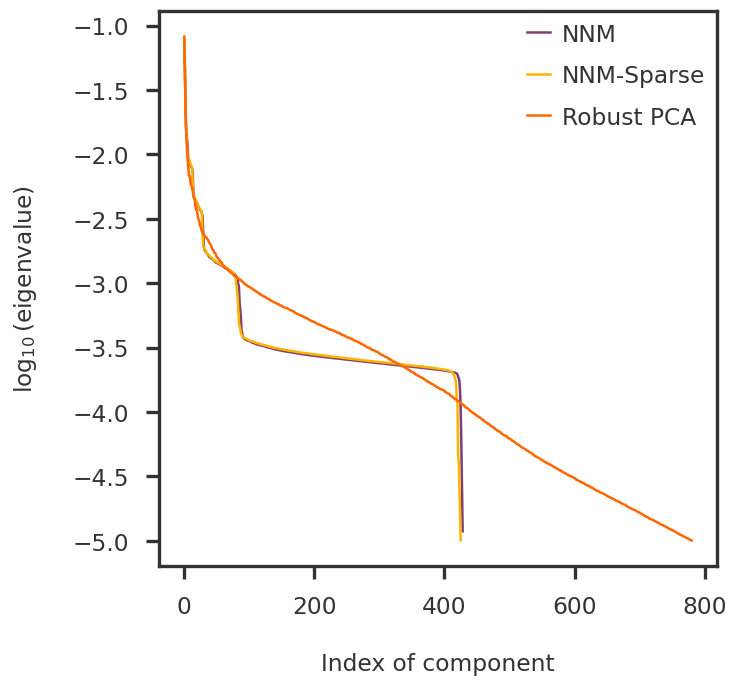

In [51]:
method_names = {
    "nnm" : "NNM",
    "nnm-sparse" : "NNM-Sparse",
    "rpca" : "Robust PCA"
}

fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
for method in methods:
    eigvals = eigenvalues[method]
    logeigvals = np.log10(eigvals[eigvals>1e-5])
    # logeigvals = np.log10(eigenvalues[method])
    # logeigvals = eigenvalues[method]
    ax1.plot(np.arange(logeigvals.shape[0]), logeigvals, label = method_names[method])

ax1.set_xlabel("Index of component")
ax1.set_ylabel(r"$\log_{10}$(eigenvalue)")
ax1.legend()
plt.show()

In [35]:
k = 200
for method in methods:
    U, S, V = pca_res[method]
    loadings = U[:, :k] @ np.diag(S[:k])
    factors = V[:, :k]
    cos2_pheno = compute_cos(loadings)
    cos2_variant = compute_cos(factors)
    contribution_pheno   = compute_contribution(loadings)
    contribution_variant = compute_contribution(factors)
    filename = os.path.join(result_dir, method, "noRx", f"mf_comps_k{k}.pkl")
    with open(filename, "wb") as mfile:
        pickle.dump((loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant), mfile, protocol = pickle.HIGHEST_PROTOCOL)

In [36]:
loadings.shape

(2110, 200)

In [37]:
factors.shape

(51368, 200)

In [52]:
for method in methods:
    nucnorm = np.linalg.norm(lowX[method], ord='nuc')
    print (method, nucnorm)

nnm 107147.38379098223
nnm-sparse 106525.77886519612
rpca 147300.30652478678


In [55]:
sparseX = dict()
sparseX['nnm-sparse'] = model['nnm-sparse']['M_']
sparseX['rpca'] = model['rpca']['E_']
for method in methods:
    if method in sparseX.keys():
        l1norm = np.linalg.norm(sparseX[method], ord=1)
        print(method, l1norm)

nnm-sparse 219.25130828175318
rpca 1904.994794867643


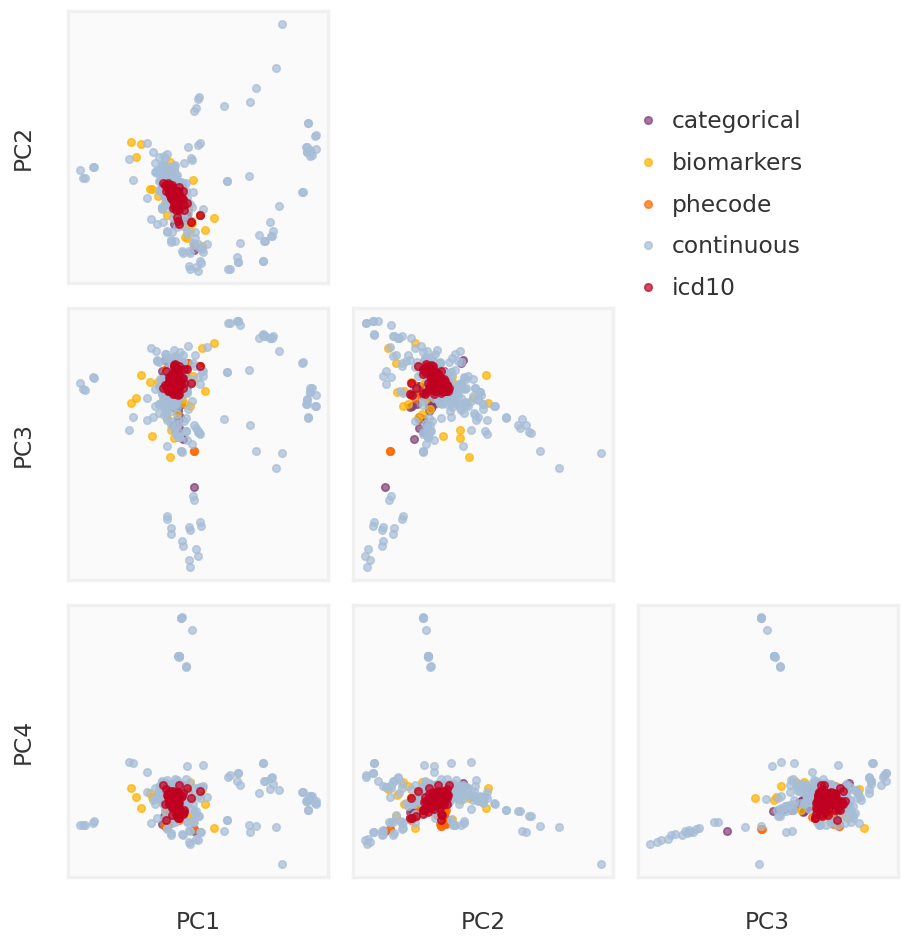

In [47]:
import sys
sys.path.append("../utils/")
import plot_functions as mpy_plotfn

pca_res["raw"] = get_principal_components(X_cent)
pheno_zindex = [int(x[1:]) for x in zscore_df.columns]
trait_df_noRx = trait_df.loc[trait_df['zindex'].isin(pheno_zindex)]

U, S, V = pca_res["raw"]
labels = trait_df_noRx['trait_type'].to_list()
unique_labels = list(set(labels))
axmain, axs = mpy_plotfn.plot_principal_components(U @ np.diag(S), labels, unique_labels, ncomp = 4)
plt.show()